In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import torch.nn.functional as F
import torch.optim as optim
import math

from sklearn.preprocessing import normalize

In [2]:
from Data_interpret.GroundTruth import ReadMat
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from Robofly_simulator.robot import Robot
import sys


In [3]:


# Loading DATA
project_folder = Path("E:/Dropbox/Daksh/System_ID_project/system_identificatification_robofly/")  # windows path
data_folder = Path("Raw_data/8_8_2019 to 8_12_2019/")
train_file = project_folder / data_folder / "2019-08-08-19-16-02_5sec.mat"
train_file2 = project_folder / data_folder / "2019-08-09-13-01-42_10sec.mat"
train_data = ReadMat(train_file)
train_data2 = ReadMat(train_file2)
# train_data = ReadMat(train_file2)

test_file = project_folder / data_folder / "2019-08-09-12-49-56_7sec.mat"
test_data = ReadMat(test_file)

# SAMPLING DATA
sample_size = 100  # sampling of raw data
train_state_traj, train_action_traj = train_data.sampled_mocap_data(sample_size)  # state X time, number of actions X time
train_state_traj2, train_action_traj2 = train_data2.sampled_mocap_data(sample_size)  # state X time, number of actions X time
test_state_traj, test_action_traj = test_data.sampled_mocap_data(sample_size)

In [4]:
print("train_shape",train_state_traj.shape,"train_action_shape", train_action_traj.shape)
print("train2_shape",train_state_traj2.shape,"train2_action_shape", train_action_traj2.shape)
print("test_shape",test_state_traj.shape,"test_action_traj", test_action_traj.shape)
train_sa1 = np.concatenate((train_state_traj,train_action_traj),axis=0)# train state action trajecctory
train_sa2 = np.concatenate((train_state_traj2,train_action_traj2),axis=0)## train state action trajecctory2
test_sa = np.concatenate((test_state_traj,test_action_traj),axis=0)# test state action trajecctory


train_shape (9, 553) train_action_shape (3, 553)
train2_shape (9, 1056) train2_action_shape (3, 1056)
test_shape (9, 756) test_action_traj (3, 756)


In [ ]:
compare= train_state_traj[:,1:]- train_state_traj[:,:-1]
plt.plot(compare.T[:,0:2])

In [96]:
class RoboFlyDataset(torch.utils.data.Dataset):
    def __init__(self, Data_chunks, sequence_length, batch_size,transform=None):
        super(RoboFlyDataset, self).__init__()
        #Data_chunks= [# of chunks, # of timesteps in 1 chunk, # of states + # of actions]
        self.sequence_length = sequence_length
        self.batch_size = batch_size# sequences in a batch
        
        assert self.batch_size == Data_chunks.shape[0]
        self.transform= transform
        self.n= Data_chunks.shape[0]*Data_chunks.shape[1] #total timesteps
        self.dataset,self.labels= self.generate_data_labels(Data_chunks)
        # TODO: Any preprocessing on the data to get it to the right shape.
        self.time_steps_in_a_batch= self.batch_size*self.sequence_length
        self.no_of_batches= math.floor(self.n/(self.time_steps_in_a_batch))
        
              
    def __len__(self):
        # TODO return the number of unique sequences you have, not the number of time steps.
        no_of_sequences = self.no_of_batches*self.batch_size
        #print('sequences',no_of_sequences)
        return no_of_sequences
    def generate_data_labels(self,Data_chunks):
        for i in range(Data_chunks.shape[0]):
            if i==0:
                dataset= Data_chunks[i,:-1,9:12]
                labels= Data_chunks[i,1:,0:9]- Data_chunks[i,:-1,0:9]
                #assert dataset.shape==labels.shape
            else:
                data= Data_chunks[i,:-1,9:12]
                label= Data_chunks[i,1:,0:9]- Data_chunks[i,:-1,0:9]
                #assert data.shape==label.shape
                dataset= np.concatenate((dataset,data),axis=0)
                labels= np.concatenate((labels,label),axis=0)
        if (self.transform):
            dataset= normalize(dataset)
        print('datset_size',dataset.shape,labels.shape)
        return dataset,labels
        
    def __getitem__(self, idx):
        # Return the data and label for a time sequence as described above.
        # The data and labels should be torch long tensors.
        # You should return a single entry for the batch using the idx to decide which chunk you are 
        # in and how far down in the chunk you are.
        location= idx*self.sequence_length
        numpy_data= self.dataset[location:location+self.sequence_length][:]
        if self.transform:
            data= torch.FloatTensor(normalize(numpy_data))
        else:
            data= torch.FloatTensor(numpy_data)
        label= torch.FloatTensor(self.labels[location:location+self.sequence_length][:])
        return (data,label)

In [97]:
TEMPERATURE = 0.5

class LSTMRoboflyNet(nn.Module):
    def __init__(self, input_size, output_size, LSTM_output):
        super(LSTMRoboflyNet, self).__init__()
        self.output_size = output_size
        self.input_size = input_size
        self.LSTM_output= LSTM_output
        #self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.LSTM = nn.LSTM(self.input_size, self.LSTM_output, num_layers=1, batch_first=True, bidirectional=False)
        self.fc1 = nn.Linear(self.LSTM_output,self.output_size)
        #self.fc2 = nn.Linear(50,self.output_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        #self.decoder.weight = self.encoder.weight
        #self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1

    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        output,hidden_state= self.LSTM(x.view(batch_size,sequence_length,-1),hidden_state)
        output= self.fc1(output)
        #output= self.fc2(output)
        # TODO finish defining the forward pass.
        

        return output, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        #x = x / max(temperature, 1e-20)
        #x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        #print('MSE',prediction.view(-1, self.output_size).size(),label.view(-1,self.output_size).size())
        loss_val = nn.MSELoss( reduction=reduction)(prediction, label)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

In [98]:
def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)
check_data=[]
check_label=[]
def train(model, device, train_loader, lr, epoch, log_interval,init_states):
    model.train()
    losses = []
    #init0 = torch.FloatTensor(init_states)
    #cell = torch.zeros((init0.size()))
    #hidden= (init0,cell)
    hidden =None
    for batch_idx, (data, label) in enumerate(train_loader):      
        data, label = data.to(device), label.to(device)
        check_data.append(data[0])
        check_label.append(label)
        # Separates the hidden state across batches. 
        # Otherwise the backward would try to go all the way to the beginning every time.
        if hidden is not None:
            hidden = repackage_hidden(hidden)
        optimizer.zero_grad()
        output, hidden = model(data, hidden)
        #pred = output.max(-1)[1]
        #print('train',output.size(),label.size())
        loss = model.loss(output, label)
        
        losses.append(loss.item())
        loss.backward(retain_graph=True)
        optimizer.step()
        if batch_idx % log_interval == 0:
            #print(data.size(),label.size())
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)


def test(model, device, test_loader,init_state):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        #init0 = torch.FloatTensor(init_state)
        #cell = torch.zeros((init0.size()))
        #hidden= (init0,cell)
        hidden= None
        all_output=[]
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output, hidden = model(data, hidden)
            test_loss += model.loss(output, label, reduction='mean').item()
            all_output.append(output)
#             pred = output
#             correct_mask = pred.eq(label.view_as(pred))
#             num_correct = correct_mask.sum().item()
#             correct += num_correct
#             # Comment this out to avoid printing test results
#             if batch_idx % 10 == 0:
#                 print('Input\t%s\nGT\t%s\npred\t%s\n\n' % (
#                     train_loader.dataset.vocab.array_to_words(data[0]),
#                     train_loader.dataset.vocab.array_to_words(label[0]),
#                     train_loader.dataset.vocab.array_to_words(pred[0])))
            
    test_loss /= len(test_loader)
    #test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)

    print('\nTest set: Average loss: {:.4f}'.format(test_loss))
    return test_loss,all_output

In [110]:
#defining parameters
SEQUENCE_LENGTH = 20
BATCH_SIZE = 3
FEATURE_SIZE = 3
TEST_BATCH_SIZE = 1
EPOCHS = 30 #going through the whole data how many times
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0005
USE_CUDA = False
PRINT_INTERVAL = 20
LOG_PATH = 'logs/log.pkl'
input_size= 3
output_size= 9
#making train data chunks
chunk1 = train_sa1[:,25:526]#(12, 501)cutting 0.25 seconds from beginning
chunk2 = train_sa2[:,25:526]#(12, 501)cutting 0.25 seconds from beginning
chunk3 = train_sa2[:,526:1027]#(12, 501)cutting 0.25 seconds from beginning
train_init_states= np.vstack((train_state_traj[:,25],train_state_traj2[:,25],train_state_traj2[:,526]))#(9,3)
train_init_states= train_init_states.T.reshape((1,3,-1))#(3,9)
data_chunks= []
data_chunks.append(chunk1.T);data_chunks.append(chunk3.T);data_chunks.append(chunk3.T);data_chunks= np.asarray(data_chunks)
#print(data_chunks.shape)#(3,501,12)
#making test data
temp_test= test_sa.T
test_chunk= temp_test[25:726,:]
test_data_chunk= test_chunk.reshape((TEST_BATCH_SIZE,-1,12))
#making initial state
test_init_state= test_state_traj[:,25].reshape((1,1,-1))
#print("test_data",test_data_chunk.shape)
#DATA tranformation
train_transforms = True

#defining data set objects
data_train = RoboFlyDataset(data_chunks, SEQUENCE_LENGTH, BATCH_SIZE,train_transforms)
data_test = RoboFlyDataset(test_data_chunk, SEQUENCE_LENGTH, TEST_BATCH_SIZE,train_transforms)

#if using CUDA
use_cuda = USE_CUDA and torch.cuda.is_available()

device = torch.device("cuda" if use_cuda else "cpu")
print('Using device', device)
import multiprocessing
num_workers = multiprocessing.cpu_count()
print('num workers:', num_workers)

kwargs = {'num_workers': num_workers,
          'pin_memory': True} if use_cuda else {}

#data loader objects
train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                           shuffle=False, **kwargs)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                          shuffle=False, **kwargs)

#model definition
model = LSTMRoboflyNet(input_size, output_size,100).to(device)

# Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
start_epoch = 0#model.load_last_model(DATA_PATH + 'checkpoints')
#parameters for tracking losses
train_losses=[]; test_losses=[]
#train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
test_loss,output = test(model, device, test_loader,test_init_state)

test_losses.append((start_epoch, test_loss))


try:
    for epoch in range(start_epoch, EPOCHS + 1):
        lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
        train_loss = train(model, device, train_loader, lr, epoch, PRINT_INTERVAL,train_init_states)
        test_loss,output= test(model, device, test_loader,test_init_state)
        train_losses.append((epoch, train_loss))
        test_losses.append((epoch, test_loss))
        #test_accuracies.append((epoch, test_accuracy))
        #pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
        #model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/%03d.pt' % epoch)
        #seed_words = 'Harry Potter'
        #for ii in range(10):
        #   generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
        #    print('generated sample\t', generated_sentence)
        #generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
        #print('generated beam\t\t', generated_sentence)
        #print('')

except KeyboardInterrupt as ke:
    print('Interrupted')
except:
    import traceback
    traceback.print_exc()
finally:
    print('Saving final model')
    #model.save_model(DATA_PATH + 'checkpoints/%03d.pt' % epoch, 0)

datset_size (1500, 3) (1500, 9)
datset_size (700, 3) (700, 9)
Using device cpu
num workers: 4

Test set: Average loss: 0.0727
Train Epoch: 0 [0/75 (0%)]	Loss: 0.180128
Train Epoch: 0 [60/75 (80%)]	Loss: 0.118441

Test set: Average loss: 0.0678
Train Epoch: 1 [0/75 (0%)]	Loss: 0.173146
Train Epoch: 1 [60/75 (80%)]	Loss: 0.111690

Test set: Average loss: 0.0657
Train Epoch: 2 [0/75 (0%)]	Loss: 0.168703
Train Epoch: 2 [60/75 (80%)]	Loss: 0.101403

Test set: Average loss: 0.0623
Train Epoch: 3 [0/75 (0%)]	Loss: 0.163518
Train Epoch: 3 [60/75 (80%)]	Loss: 0.086203

Test set: Average loss: 0.0520
Train Epoch: 4 [0/75 (0%)]	Loss: 0.154047
Train Epoch: 4 [60/75 (80%)]	Loss: 0.079632

Test set: Average loss: 0.0488
Train Epoch: 5 [0/75 (0%)]	Loss: 0.148846
Train Epoch: 5 [60/75 (80%)]	Loss: 0.076128

Test set: Average loss: 0.0473
Train Epoch: 6 [0/75 (0%)]	Loss: 0.144773
Train Epoch: 6 [60/75 (80%)]	Loss: 0.073458

Test set: Average loss: 0.0477
Train Epoch: 7 [0/75 (0%)]	Loss: 0.141480
Train 

In [111]:


for i in range(len(output)):
    output[i]=output[i].numpy()

In [112]:
output=np.asarray(output)
output.shape
output= output.reshape((-1,9))
output.shape

(700, 9)

(701,)
0.26019050665836063


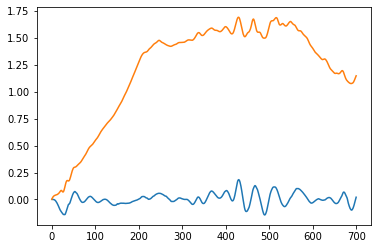

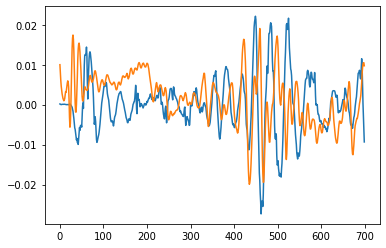

In [113]:
n=0
output_traj=[]
output_traj.append(test_chunk[0,n])

#output_traj= output_traj.reshape((9,1))

for i in range(700):
    output_traj.append(output_traj[len(output_traj)-1]+output[i,n])
    
output_traj= np.asarray(output_traj)
print(output_traj.shape)
#plt.plot(output_traj)
diff= test_state_traj[n,1:]-test_state_traj[n,:-1]
plt.plot(test_chunk[:,n])

plt.plot(output_traj)
plt.figure()
plt.plot(diff[:700])
plt.plot(output[:,n])
a= test_state_traj[n,1:]-test_state_traj[n,:-1]
b= output[:,n]
print(np.linalg.norm(a[0:700]-b))

#     if i==0:
#         output_traj= np.concatenate((output_traj,output_traj+output[i,:].reshape(9,1)),axis= 1)
#     else:
#         temp=output_traj[:,-1]
        
#         output_traj= np.concatenate((output_traj,temp.reshape(9,1)+output[i,:].reshape(9,1)),axis=1)
# print(output_traj.shape)

In [ ]:
plt.plot(output_traj[:,0])
plt.figure()
plt.plot(output_traj[:,1])
plt.figure()
plt.plot(output_traj[:,2])
plt.figure()
plt.plot(output_traj[:,3])
plt.figure()
plt.plot(output_traj[:,4])
plt.figure()
plt.plot(output_traj[:,5])
plt.figure()
plt.plot(output_traj[:,6])
plt.figure()
plt.plot(output_traj[:,7])
plt.figure()
plt.plot(output_traj[:,8])
plt.figure()
plt.plot(output_traj[:,9])


In [ ]:
temp_test.shape
